### **Data Bootcamp Final Project (Predictive Modeling Portion): Analysis and Predictions on Music Popularity & Streaming Data of the Most Popular Songs**

**Objectives of the project**

1. Create models to predict a song's popularity based on its quantitiative and qualitative characteristics.
2. Test the model and see where improvements can be made.


In [199]:
#import necessary libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_transformer
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures
from sklearn.datasets import make_blobs
from sklearn import set_config
from matplotlib import colormaps

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
set_config('display')

### Import the dataset again





**Mount Google Drive and Import Kaggle Dataset**

In [200]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [201]:
!pip install kagglehub

In [202]:
import kagglehub
import os
import zipfile
# Download latest version
os.environ['KAGGLE_CONFIG_DIR'] = '/content/drive/MyDrive/kaggle'

!kaggle datasets download -d solomonameh/spotify-music-dataset

zip_path = "/content/spotify-music-dataset.zip"

# Extract the zip file to the same directory
extract_path = "/content"
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# List extracted files
print("Extracted files:", os.listdir(extract_path))

# Define correct file paths
high_popularity_path = os.path.join(extract_path, "high_popularity_spotify_data.csv")




Dataset URL: https://www.kaggle.com/datasets/solomonameh/spotify-music-dataset
License(s): DbCL-1.0
spotify-music-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)
Extracted files: ['.config', 'spotify-music-dataset.zip', 'low_popularity_spotify_data.csv', 'high_popularity_spotify_data.csv', 'drive', 'sample_data']


In [203]:
df_pop = pd.read_csv(high_popularity_path)
df_pop.head()

,energy,tempo,danceability,playlist_genre,loudness,liveness,valence,track_artist,time_signature,speechiness,...,instrumentalness,track_album_id,mode,key,duration_ms,acousticness,id,playlist_subgenre,type,playlist_id
0,0.592,157.969,0.521,pop,-7.777,0.122,0.535,"Lady Gaga, Bruno Mars",3,0.0304,...,0.0000,10FLjwfpbxLmW8c25Xyc2N,0,6,251668,0.3080,2plbrEY59IikOBgBGLjaoe,mainstream,audio_features,37i9dQZF1DXcBWIGoYBM5M
1,0.507,104.978,0.747,pop,-10.171,0.117,0.438,Billie Eilish,4,0.0358,...,0.0608,7aJuG4TFXa2hmE4z1yxc3n,1,2,210373,0.2000,6dOtVTDdiauQNBQEDOtlAB,mainstream,audio_features,37i9dQZF1DXcBWIGoYBM5M
2,0.808,108.548,0.554,pop,-4.169,0.159,0.372,Gracie Abrams,4,0.0368,...,0.0000,0hBRqPYPXhr1RkTDG3n4Mk,1,1,166300,0.2140,7ne4VBA60CxGM75vw0EYad,mainstream,audio_features,37i9dQZF1DXcBWIGoYBM5M
3,0.910,112.966,0.670,pop,-4.070,0.304,0.786,Sabrina Carpenter,4,0.0634,...,0.0000,4B4Elma4nNDUyl6D5PvQkj,0,0,157280,0.0939,1d7Ptw3qYcfpdLNL5REhtJ,mainstream,audio_features,37i9dQZF1DXcBWIGoYBM5M
4,0.783,149.027,0.777,pop,-4.477,0.355,0.939,"ROSÉ, Bruno Mars",4,0.2600,...,0.0000,2IYQwwgxgOIn7t3iF6ufFD,0,0,169917,0.0283,5vNRhkKd0yEAg8suGBpjeY,mainstream,audio_features,37i9dQZF1DXcBWIGoYBM5M


Check if there are enough rows/columns to satisfy the requirements of this project

In [204]:
df_pop.shape

#enough rows & columns for requirements of this project

(1686, 29)

In [205]:
df_pop['track_popularity']

,track_popularity
0,100
1,97
2,93
3,81
4,98
...,...
1681,76
1682,74
1683,69
1684,82


Check all the column names

In [206]:
#see the column names of each
print(df_pop.columns)

Index(['energy', 'tempo', 'danceability', 'playlist_genre', 'loudness',
       'liveness', 'valence', 'track_artist', 'time_signature', 'speechiness',
       'track_popularity', 'track_href', 'uri', 'track_album_name',
       'playlist_name', 'analysis_url', 'track_id', 'track_name',
       'track_album_release_date', 'instrumentalness', 'track_album_id',
       'mode', 'key', 'duration_ms', 'acousticness', 'id', 'playlist_subgenre',
       'type', 'playlist_id'],
      dtype='object')


In [207]:
# Drop columns that are not useful for modeling
columns_to_drop = ['track_href', 'uri', 'track_album_name', 'playlist_name',
                   'analysis_url', 'track_id', 'track_name', 'track_album_release_date',
                   'track_album_id', 'id', 'type', 'playlist_id']

df_pop = df_pop.drop(columns=[col for col in columns_to_drop if col in df_pop.columns])

## Building, Testing, and Interpretting Different Predictive Models
---



First, I'm going to try building basic linear regression and KNN models for prediction

The blurb below starts model process w/ pre-processing & splitting test/train datasets

In [208]:
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
import pandas as pd

# Separate target and features
target = 'track_popularity'
X = df_pop.drop(columns=[target])
y = df_pop[target]

# Identify types of features
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X.select_dtypes(include=['object']).columns.tolist()

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Preprocessing
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer([
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])

**Linear Regression Model**

In [209]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Pipeline
linear_model = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

# Fit
linear_model.fit(X_train, y_train)

# Predict and evaluate
y_pred_lr = linear_model.predict(X_test)
print("Linear Regression:")
print("MSE:", mean_squared_error(y_test, y_pred_lr))
print("R²:", r2_score(y_test, y_pred_lr))

Linear Regression:
MSE: 26.185250780894116
R²: 0.23170188050524254


KNN model (w/ optimized number of k neighbors) - using 5-fold cross-validation on the training data

In [210]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsRegressor

# Define the pipeline
knn_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', KNeighborsRegressor())
])

# Define hyperparameter grid for n_neighbors
param_grid = {
    'regressor__n_neighbors': list(range(1, 21))  # Try k = 1 to 20
}

# GridSearchCV to find best k
grid_search = GridSearchCV(knn_pipeline, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Best K and corresponding model
print("Best k:", grid_search.best_params_['regressor__n_neighbors'])

# Evaluate on test data
best_knn_model = grid_search.best_estimator_
y_pred_best_knn = best_knn_model.predict(X_test)

print("\nTest MSE:", mean_squared_error(y_test, y_pred_best_knn))
print("Test R²:", r2_score(y_test, y_pred_best_knn))

Best k: 11

Test MSE: 28.294244217321136
Test R²: 0.1698221717794458


**Takeaways from the Simple Regression & KNN models:**

As we can see from the results, neither is ideal, as both R^2 values are within the 0.1-0.25 region, which tells us that our model only captures at most 25% of the variance in popularity scores.

However between the two models, I was a little surprised to see that the basic linear regression model actually outperformed the KNN model (even after optimizing for the best number of k neighbors via GridSearch).

Ultimately, because both models were less than ideal, I decided to try adding more complexity to the linear model, including polynomial features.

In [213]:
# Extract primary artist for consistency
df_pop['primary_artist'] = df_pop['track_artist'].apply(lambda x: x.split(',')[0])

In [211]:
from sklearn.preprocessing import PolynomialFeatures

# Build a new pipeline for polynomial regression (degree 2)
poly_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),  # same as used earlier
    ('poly', PolynomialFeatures(degree=2, include_bias=False)),
    ('regressor', LinearRegression())
])

# Fit
poly_pipeline.fit(X_train, y_train)

# Predict
y_poly_pred = poly_pipeline.predict(X_test)

# Evaluate
poly_mse = mean_squared_error(y_test, y_poly_pred)
poly_r2 = r2_score(y_test, y_poly_pred)
print(f"Polynomial Regression MSE: {poly_mse:.2f}")
print(f"Polynomial Regression R^2: {poly_r2:.2f}")

Polynomial Regression MSE: 181.61
Polynomial Regression R^2: -4.33


The previous polynomial model did horribly, with a R^2 of -4.33% -- indicating that the model's predictions are worse than simply using the mean of the dependent variable as a prediction

I want to try the model again, but with a different regressor.

In [214]:
from sklearn.linear_model import Ridge
poly_features = PolynomialFeatures(degree=2, include_bias=False)

# Use only numeric columns for polynomial
poly_pipeline = Pipeline(steps=[
    ('poly', poly_features),
    ('scaler', StandardScaler()),
    ('regressor', Ridge(alpha=1.0))
])

num_features = df_pop[features].select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_features = df_pop[features].select_dtypes(include=['object']).columns.tolist()

X_num = df_pop[num_features]
X_train_poly, X_test_poly, y_train_poly, y_test_poly = train_test_split(X_num, y, test_size=0.2, random_state=42)

poly_pipeline.fit(X_train_poly, y_train_poly)
y_pred_poly = poly_pipeline.predict(X_test_poly)

mse_poly = mean_squared_error(y_test_poly, y_pred_poly)
r2_poly = r2_score(y_test_poly, y_pred_poly)

print(f"Polynomial Ridge MSE: {mse_poly:.2f}")
print(f"Polynomial Ridge R^2: {r2_poly:.2f}")

Polynomial Ridge MSE: 34.91
Polynomial Ridge R^2: -0.02


This time around, with the Ridge regressor instead of the Linear regressor, the MSE dropped significantly from 181 to ~35, almost a 4.5x difference.

However, the R^2 value is still negative, so I doubt that this model is any good either.

**Random Forest Regressor**

Because the polynomial models did even worse than the simple regression model we started with, I'm going to try a random forest regressor next and see if it's any better.

MSE: 20.06
R^2: 0.41


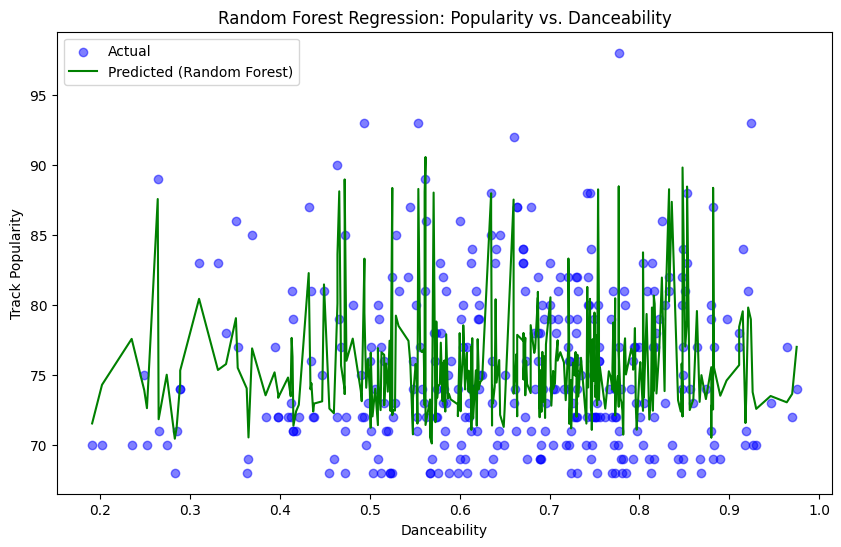

In [217]:
# Drop original 'track_artist' column
df_pop.drop(columns=['track_artist'], inplace=True)

# Define feature columns and target
target = 'track_popularity'
features = df_pop.drop(columns=[target]).columns.tolist()

# Separate features by type
numeric_features = df_pop[features].select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = df_pop[features].select_dtypes(include=['object']).columns.tolist()

# Preprocessing
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Build the pipeline
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(random_state=42))
])

# Split data
X = df_pop[features]
y = df_pop[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the model
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)

# Evaluate
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"MSE: {mse:.2f}")
print(f"R^2: {r2:.2f}")


# Sort values for a smoother visualization
sorted_idx = X_test['danceability'].argsort()
x_sorted = X_test['danceability'].values[sorted_idx]
y_actual_sorted = y_test.values[sorted_idx]
y_pred_sorted = y_pred[sorted_idx]


# Visualization
plt.figure(figsize=(10, 6))
plt.scatter(x_sorted, y_actual_sorted, label='Actual', color='blue', alpha=0.5)
plt.plot(x_sorted, y_pred_sorted, label='Predicted (Random Forest)', color='green')
plt.xlabel('Danceability')
plt.ylabel('Track Popularity')
plt.title('Random Forest Regression: Popularity vs. Danceability')
plt.legend()
plt.show()

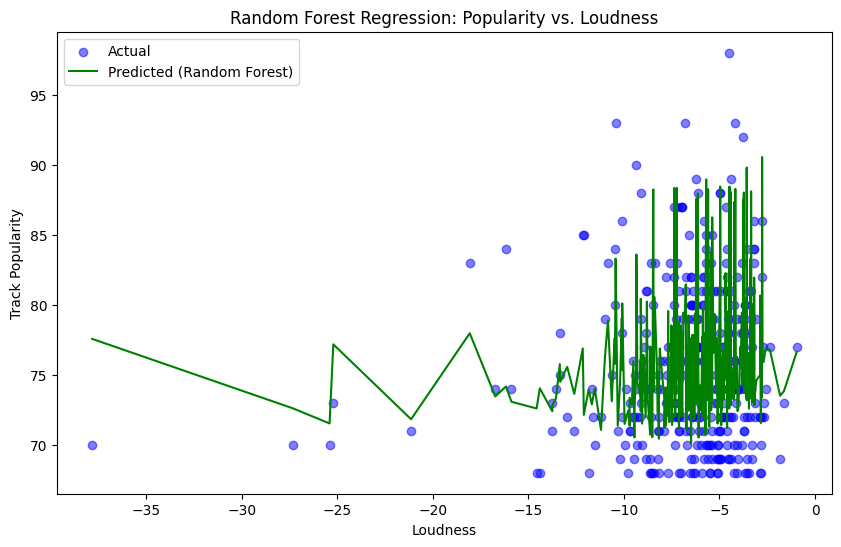

In [218]:
# Sort values for a smoother visualization
sorted_idx = X_test['loudness'].argsort()
x_sorted = X_test['loudness'].values[sorted_idx]
y_actual_sorted = y_test.values[sorted_idx]
y_pred_sorted = y_pred[sorted_idx]


# Visualization
plt.figure(figsize=(10, 6))
plt.scatter(x_sorted, y_actual_sorted, label='Actual', color='blue', alpha=0.5)
plt.plot(x_sorted, y_pred_sorted, label='Predicted (Random Forest)', color='green')
plt.xlabel('Loudness')
plt.ylabel('Track Popularity')
plt.title('Random Forest Regression: Popularity vs. Loudness')
plt.legend()
plt.show()

In [219]:
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"MSE: {mse:.2f}")
print(f"R^2: {r2:.2f}")

MSE: 20.06
R^2: 0.41


count    1686.000000
mean       75.806050
std         6.032532
min        68.000000
25%        71.000000
50%        75.000000
75%        79.000000
max       100.000000
Name: track_popularity, dtype: float64


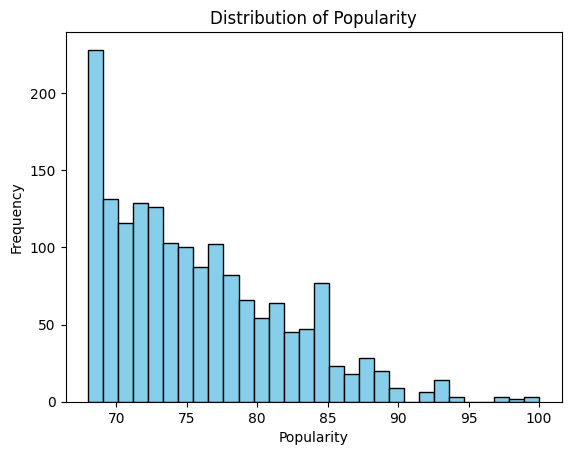

In [220]:
pop_stats = df_pop['track_popularity'].describe()
print(pop_stats)

# Optional: Histogram for visualization
plt.hist(df_pop['track_popularity'], bins=30, color='skyblue', edgecolor='black')
plt.title("Distribution of Popularity")
plt.xlabel("Popularity")
plt.ylabel("Frequency")
plt.show()

**Decision Tree Model for Track Popularity**

In [221]:
from sklearn.tree import DecisionTreeRegressor

# Decision Tree pipeline
tree_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', DecisionTreeRegressor(max_depth=5, random_state=42))
])

In [222]:
X = df_pop[features]
y = df_pop[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit the model
tree_pipeline.fit(X_train, y_train)

# Predict
y_pred_tree = tree_pipeline.predict(X_test)

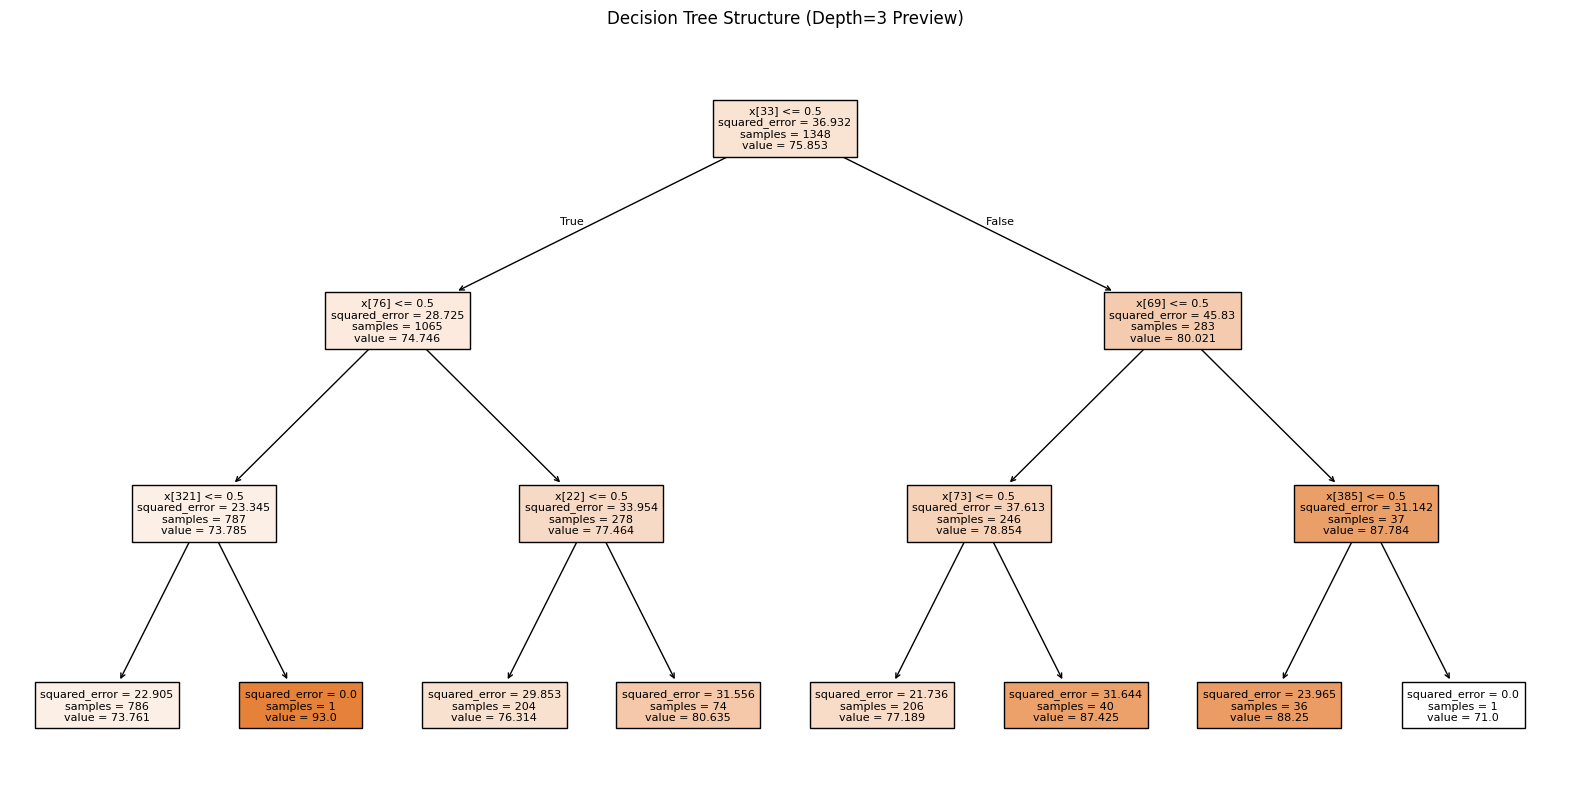

In [223]:
from sklearn import tree

# Fit tree outside pipeline for visualization
tree_model = DecisionTreeRegressor(max_depth=3, random_state=42)
X_preprocessed = preprocessor.fit_transform(X_train)
tree_model.fit(X_preprocessed, y_train)

#plot the tree & visualize decision paths
plt.figure(figsize=(20, 10))
tree.plot_tree(tree_model, filled=True, fontsize=8)
plt.title("Decision Tree Structure (Depth=3 Preview)")
plt.show()

In [224]:
mse_tree = mean_squared_error(y_test, y_pred_tree)
r2_tree = r2_score(y_test, y_pred_tree)

print(f"Decision Tree MSE: {mse_tree:.2f}")
print(f"Decision Tree R^2: {r2_tree:.2f}")

Decision Tree MSE: 26.71
Decision Tree R^2: 0.22


In [225]:
from sklearn.inspection import permutation_importance

# Encode and convert to dense
X_train_encoded = preprocessor.transform(X_train).toarray()
X_test_encoded = preprocessor.transform(X_test).toarray()

# Fit decision tree
dtree = DecisionTreeRegressor(max_depth=5, random_state=42)
dtree.fit(X_train_encoded, y_train)

# Permutation importance
r = permutation_importance(dtree, X_test_encoded, y_test, n_repeats=10, random_state=42)

# Feature names
feature_names = preprocessor.get_feature_names_out()

# Format results
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': r.importances_mean
}).sort_values(by='Importance', ascending=False)

# Show top 10
print(importance_df.head(10))

                               Feature  Importance
33             cat__playlist_genre_pop    0.229055
76       cat__playlist_subgenre_modern    0.107638
69       cat__playlist_subgenre_global    0.068582
22          cat__playlist_genre_gaming    0.055156
11                    num__duration_ms    0.025819
705     cat__primary_artist_The Weeknd    0.020248
321     cat__primary_artist_Gigi Perez    0.018654
73   cat__playlist_subgenre_mainstream    0.016057
8                num__instrumentalness    0.004156
30           cat__playlist_genre_latin    0.001903


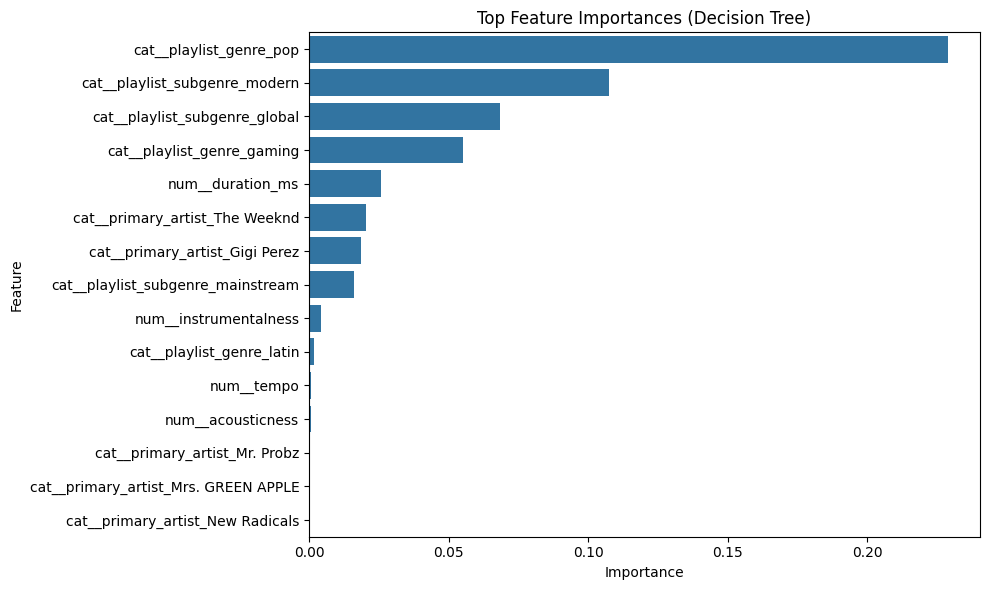

In [226]:
top_n = 15
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df.head(top_n))
plt.title('Top Feature Importances (Decision Tree)')
plt.tight_layout()
plt.show()

The model's weighting in 'top features' actually makes a good amount of sense as it identified some of the most correlated features with popularity that we discovered during our EDA phase, like genre.

Also, it put a significant weighting on duration, which we also discovered during EDA was a major quantitative determinant of a song's popularity.

Lastly, it's interesting to see that the model identified some specific artists like The Weeknd, who consistently make popular/hit songs.


## Reflections, Next Steps, and Improvements

**Main takeaways:**

I found that certain complex models fared better than simpler models (ie in the case of the random forests model performing better than KNN and regression in terms of R^2 and MSE). However, there were also cases when more complicated models simply did worse than their simpler counterparts. In the case of the linear model that factored in polynomial features, it received a negative R^2 and a significantly worse MSE and R^2 than a simple linear regression.

Another key takeaway is that none of the models did particularly well, as the highest R^2 was still only in the 0.4-0.5 range. The moderate R^2 values tell us that while the model might have captured some structure, music popularity is still extremely difficult to predict and it's extremely multifaceted (and maybe even has some luck/randomness involved). This would make sense as there are confounding factors like social and cultural factors, that this model simply couldn't account for.

**Next Steps:**

In terms of next steps, we could definitely have more features involved to make the model more holistic. For example, like I mentioned earlier with the social factors, maybe including external data such as YouTube or TikTok trends, playlist followers, or artist social media. In recent years, we've seen that many popular songs are also those that go extremely viral on TikTok, so I would not be surprised if there was a major correlation there.

Secondly, we could include temporal elements like release year that would reflect how music tastes change over time.

Overall, I believe that this was a good first step in predicting music popularity, but nowhere close to being useful, as our models' R^2 values are simply not good enough. In the future, I hope to incorporate some additional features/refine current models to make it more exhaustive and accurate.
